In [1]:
from sensible_raw.loaders import loader
import numpy as np
from sklearn.preprocessing import scale
from sklearn.svm import OneClassSVM
from collections import Counter, defaultdict
import sys
from datetime import datetime as dt
import json
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
from extractors.sms_extractor import Sms_extractor
from extractors.stop_locations_extractor import Stop_locations_extractor
##from screen_extractor import Screen_extractor
##from facebook_friends_extractor import Facebook_friends_extractor
from extractors.bluetooth_extractor import Bluetooth_extractor
##from calllog_extractor import Calllog_extractor
##from location_extractor import Location_extractor
from extractors.big_five_extractor import Big_five_extractor

from preproc.outlier_detection import Outlier_detector

In [3]:
load_old_datasources = True

tc0 = {'hours': range(24), 'days': range(7), 'spans': [("06/01/14","24/01/14"), ("03/02/14","16/05/14"), ("01/09/14","05/12/14"), ("02/06/14","20/06/14")]} #in school
tc1 = {'hours': range(24), 'days': range(7), 'spans': [("17/05/14","01/06/14"), ("06/12/14", "21/12/14")]} #exam periods
tc2 = {'hours': range(24), 'days': range(7), 'spans': [("01/01/14","05/01/14"), ("25/01/14","02/02/14"), ("14/04/14","20/04/14"), ("21/06/14","30/08/14"), ("22/12/14", "31/12/14")]} #holiday

sms = Sms_extractor(tc0, suppress=[], auxlabel="tc0_", load_old_datasources=load_old_datasources)
stop_locations = Stop_locations_extractor(tc0, suppress=[], auxlabel="tc0_", load_old_datasources=load_old_datasources)
##screen = Screen_extractor()
##facebook_friends = Facebook_friends_extractor()
bluetooth = Bluetooth_extractor(tc0, suppress=[], auxlabel="tc0_", load_old_datasources=load_old_datasources)
##calllog = Calllog_extractor()
##location = Location_extractor()
big_five = Big_five_extractor()

[sms] Loading datasource from local.
[sms] Number of datapoints in range: 1786225
[stop_locations] Loading datasource from local.
[stop_locations] Number of datapoints in range: 450662
[bluetooth] Loading datasource from local.
[bluetooth] Number of datapoints in range: 3312659
[big_five_extractor] Loaded data from local copy!


### Build full JSON dataset

In [4]:
with open('data_cache/users.json', 'r') as infile:
    users = [int(i) for i in json.load(infile)]

load_cached_data_sets = True

if load_cached_data_sets:
    with open('data_cache/dataset_X.json') as infile:
        dataset_X = json.load(infile)
    with open('data_cache/dataset_Y.json') as infile:
        dataset_Y = json.load(infile)
else:
    dataset_X = {}
    dataset_Y = {}

    for user in users:

        if user%10 == 0:
            print user,

        datapoint_x = {}
        datapoint_y = {}

        # Ordered by execution speed
        try:
            datapoint_x.update(stop_locations.main(user))
            datapoint_x.update(sms.main(user))
            #datapoint_x.update(screen.main(user))
            #datapoint_x.update(facebook_friends.main(user))
            datapoint_x.update(bluetooth.main(user))
            #datapoint_x.update(calllog.main(user))
            #datapoint_x.update(location.main(user))
            datapoint_y.update(big_five.main(user))
        except Exception as e:
            print "<"+str(e)+">",
            continue

        dataset_X[user] = datapoint_x
        dataset_Y[user] = datapoint_y
        
    # Store loaded data    
    with open('data_cache/dataset_X.json', 'w') as outfile:
        json.dump(dataset_X,outfile)
    with open('data_cache/dataset_Y.json', 'w') as outfile:
        json.dump(dataset_Y,outfile)    

X = np.array(X)
M = X.shape[1]

combs = []
for i in range(M):
    for j in range(M):
        if j <= i: continue
        combs.append((i,j))
        
M = len(combs)

cols, rows = 3, np.ceil(M/3.0)

plt.figure(figsize=(15,5*rows))
for c,(i,j) in enumerate(combs):
    plt.subplot(rows,cols,c)
    plt.scatter(X[:,i],X[:,j])
    
plt.show()

### Convert to matrix and standardize

In [5]:
features_x = sorted(dataset_X.items()[0][1].keys())
features_y = ['openness','conscientiousness','extraversion','aggreeableness','neuroticism']

#features_x = filter(lambda x: int(x[2]) in [1,3], features_x)

X = []
Y = []
for k,v in dataset_X.items():
    X.append([v[f] for f in features_x])
for k,v in dataset_Y.items():
    Y.append([v[f] for f in features_y])
    
X_scaled = scale(np.array(X))
#Y_scaled = scale(np.array(Y))

In [6]:
dict(zip(range(len(features_x)),features_x))

{0: u'tc0_bluetooth_social_entropy',
 1: u'tc0_sms_fractions_of_conversations_started',
 2: u'tc0_sms_overall_received_responsiveness',
 3: u'tc0_sms_overall_responsiveness',
 4: u'tc0_sms_selectivity_in_responsiveness',
 5: u'tc0_sms_traffic',
 6: u'tc0_stop_locations_geospacial_entropy'}

### Remove outliers

-9.13575648861 0.481666733742
-9.92612122215 0.890176811391
-10.9283886548 0.800845939194
-9.14317143971 0.639753832645
-9.37145198683 0.610147461327
-9.62418496286 0.700394279067
-9.88902966326 0.80890726563
-10.5986245252 0.683554567648
-8.50151899862 0.469069030987
-8.94679317643 0.669043659536
-8.81772963959 0.695985836228
-11.9577461699 0.850082614087
-9.71350697503 0.708519114994
-9.97907153402 0.938367839519
-10.0863732004 0.966215864206
-11.5773993107 0.911816805819
-10.5408173457 0.684843039666
-10.7911650655 0.591214486706
-8.92299229825 0.717946159036
-8.87541517862 0.754324480242
-9.69468227603 0.732555362681


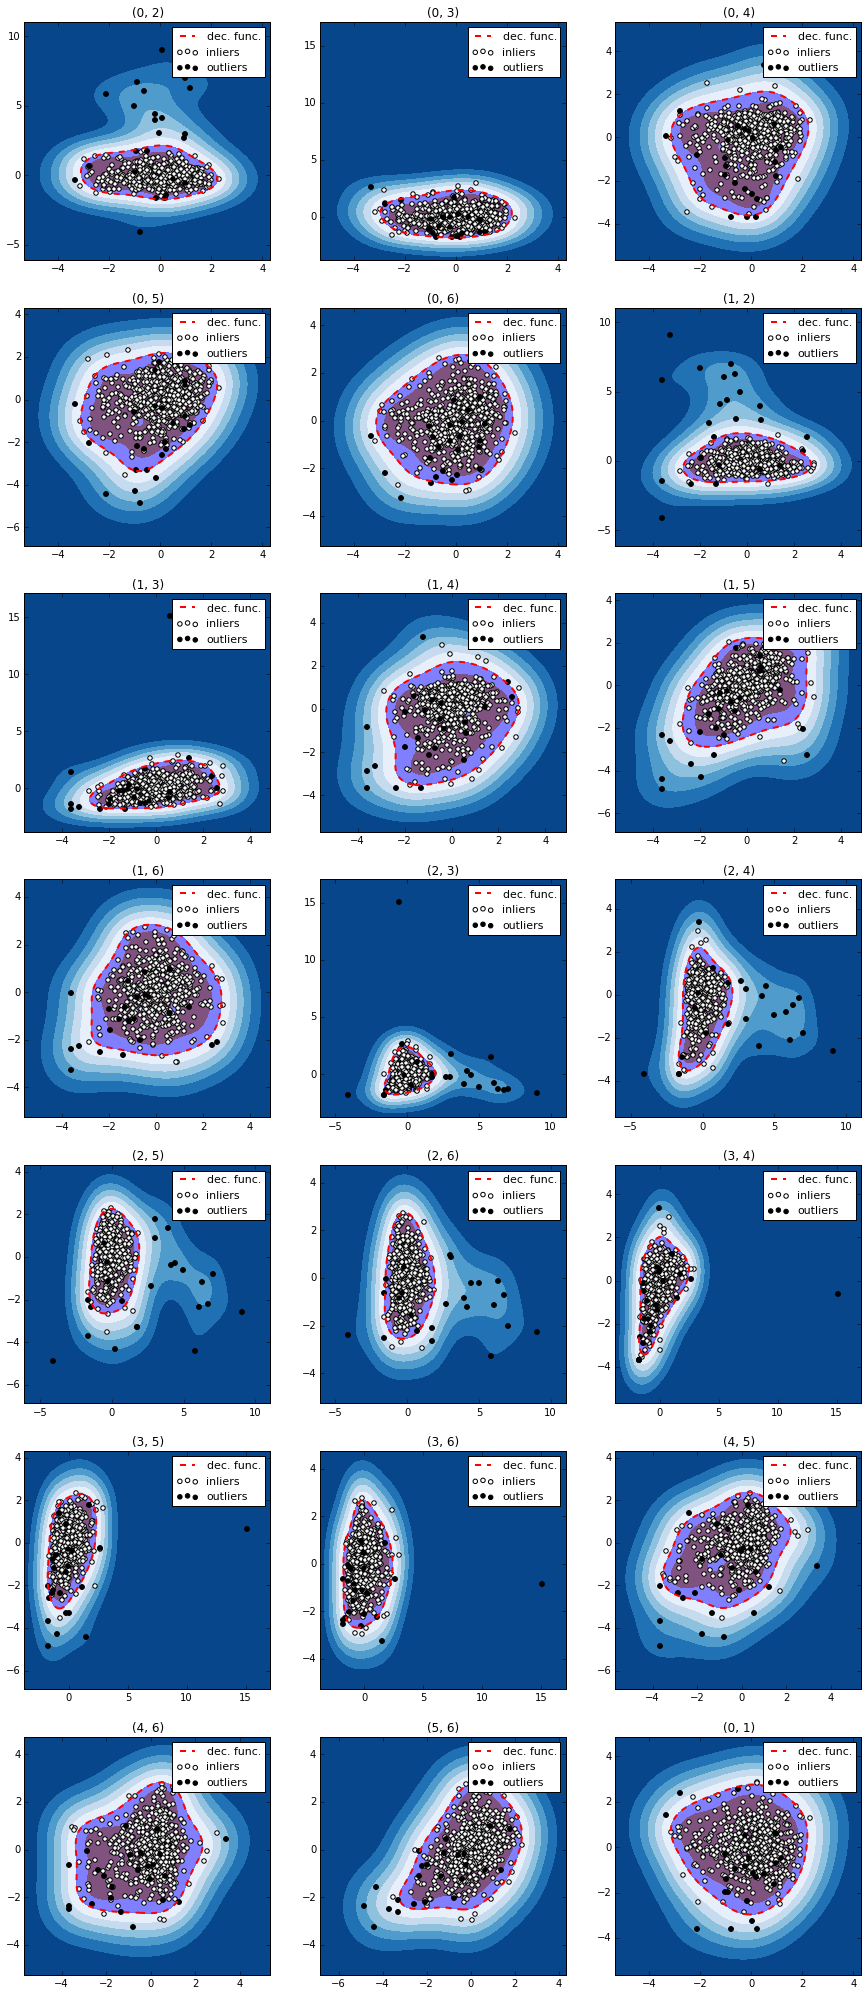

(627, 7)
(603, 7)


In [11]:
out = Outlier_detector(X_scaled,threshold=-1, visualize=True, nu=0.1, gamma=0.5)
outliers = out.main()

X_clean = np.delete(X_scaled,outliers,axis=0)
Y_clean = np.delete(Y,outliers,axis=0)

print X_scaled.shape
print X_clean.shape

#np.savetxt("data/X.csv", X_clean, delimiter=",")
#np.savetxt("data/Y.csv", Y_clean, delimiter=",")

[(0, u'tc0_bluetooth_social_entropy'), (1, u'tc0_sms_fractions_of_conversations_started'), (2, u'tc0_sms_overall_received_responsiveness'), (3, u'tc0_sms_overall_responsiveness'), (4, u'tc0_sms_selectivity_in_responsiveness'), (5, u'tc0_sms_traffic'), (6, u'tc0_stop_locations_geospacial_entropy')]


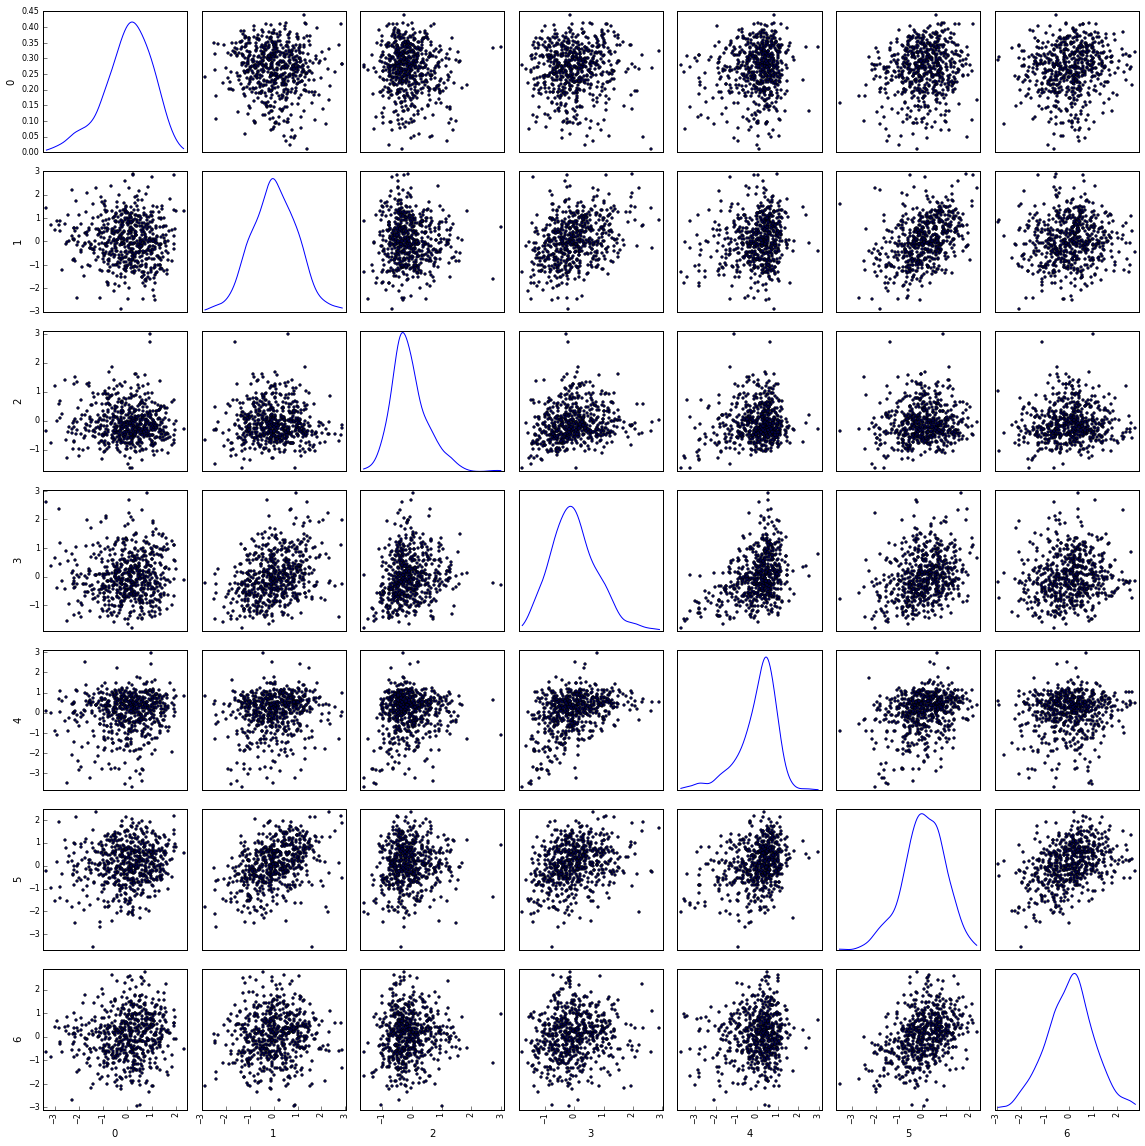

In [10]:
print zip(range(len(features_x)),features_x)
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
df = pd.DataFrame(X_clean)
pd.tools.plotting.scatter_matrix(df, alpha=1, figsize=(16,16), diagonal="kde")
plt.tight_layout()
plt.show()

In [10]:
features_x

['tc0_sms_fractions_of_conversations_started',
 'tc0_sms_overall_received_responsiveness',
 'tc0_sms_overall_responsiveness',
 'tc0_sms_selectivity_in_responsiveness',
 'tc0_sms_traffic']

In [79]:
print X_scaled.shape
print X_clean.shape

(772, 5)
(739, 5)


In [108]:
features_x

['tc0_sms_fractions_of_conversations_started',
 'tc0_sms_overall_received_responsiveness',
 'tc0_sms_overall_responsiveness',
 'tc0_sms_selectivity_in_responsiveness',
 'tc0_sms_traffic']

In [75]:
X.min()

-4.111045762890126

In [113]:
vals = [2,1,3,3,3,1,17,3,4,4,1,2,3]

In [114]:
np.mean(vals)

3.6153846153846154

In [115]:
for v in vals:
    try:
        themean = (themean+v)/2.0
    except:
        themean = v

In [132]:
component_combination = []#[(0,1),(0,2),(0,3),(0,4),(1,2),(1,3),(1,4),(2,3),(2,4),(3,4)]

In [138]:
for i in range(5):
    for j in range(5):
        if j > i:
            component_combination.append((i,j))

SyntaxError: invalid syntax (<ipython-input-138-1793cdb9a4d1>, line 1)

In [148]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])

In [154]:
np.delete(a,[0,2],axis=0)

array([[4, 5, 6]])

In [105]:
features_y

['openness',
 'extraversion',
 'neuroticism',
 'conscientiousness',
 'aggreeableness']

$$y(x) = \sum_i\alpha_ik(\mathbf{x}_i,\mathbf{x})-\rho$$